In [ ]:
import pickle
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# declare fews variables

data_path = "../asset/data/"
image_shape = (224, 224, 3)
epochs = 50
callback = lambda x: [EarlyStopping(monitor='val_loss', patience=2, mode="min"), ModelCheckpoint(filepath=f"{data_path}{x}_model.h5", monitor='val_loss', save_best_only=True)]

In [3]:
# helper function

def show_result(steps: dict):
    """
    Used to display model's results after his training
    :param steps: contains all the history of the training model
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_title("Learning curves")
    ax.set(xlabel='Epochs', ylabel='Metrics')
    sns.lineplot(x=range(len(steps["loss"])), y=steps["loss"], label="train loss", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["val_loss"], label="val loss", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["accuracy"], label="train accuracy", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["val_accuracy"], label="val accuracy", ax=ax)

## I - Load data

In [4]:
with open(f'{data_path}train_test_split.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train = data["train"]
X_test, y_test = data["test"]

## II - Custom CNN model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/50
174/174 [==============================] - 136s 766ms/step - loss: 0.4876 - accuracy: 0.7803 - val_loss: 0.3813 - val_accuracy: 0.8391
Epoch 2/50
174/174 [==============================] - 133s 762ms/step - loss: 0.3935 - accuracy: 0.8421 - val_loss: 0.3992 - val_accuracy: 0.8350
Epoch 3/50
174/174 [==============================] - 130s 745ms/step - loss: 0.3516 - accuracy: 0.8594 - val_loss: 0.4066 - val_accuracy: 0.8167


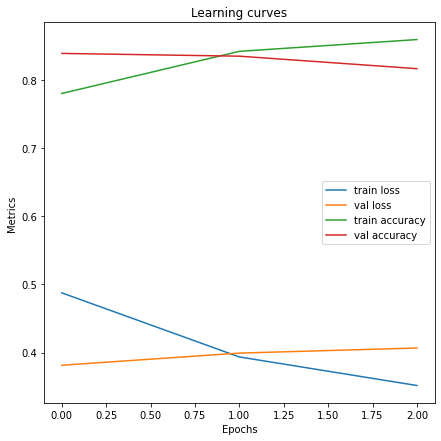

In [6]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=.15, callbacks=callback("CNet"), verbose=1).history
show_result(hist)

In [7]:
model = load_model(data_path + "CNet_model.h5")
y_pred = model.predict(X_test)
y_pred[y_pred <= 0.5], y_pred[y_pred > 0.5] = 0, 1
print("Accuracy test set:",  accuracy_score(y_test, y_pred))

Accuracy test set: 0.8326206475259621


## III - Another approach with transfer learning for feature extraction

In [8]:
# pre trained model here

#MNetV2 = MobileNetV2()
MNetV2 = load_model(data_path + "MNet_model.h5")

MNetV2_features_train = MNetV2.predict(X_train)
MNetV2_features_test = MNetV2.predict(X_test)

In [9]:
model2 = Sequential()
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/50
174/174 [==============================] - 1s 3ms/step - loss: 0.4504 - accuracy: 0.8608 - val_loss: 0.2772 - val_accuracy: 0.8921
Epoch 2/50
174/174 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.9124 - val_loss: 0.2242 - val_accuracy: 0.9165
Epoch 3/50
174/174 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9293 - val_loss: 0.2100 - val_accuracy: 0.9226
Epoch 4/50
174/174 [==============================] - 0s 2ms/step - loss: 0.1621 - accuracy: 0.9392 - val_loss: 0.2047 - val_accuracy: 0.9267
Epoch 5/50
174/174 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.9452 - val_loss: 0.2013 - val_accuracy: 0.9277
Epoch 6/50
174/174 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.9495 - val_loss: 0.1996 - val_accuracy: 0.9267
Epoch 7/50
174/174 [==============================] - 0s 2ms/step - loss: 0.1250 - accuracy: 0.9549 - val_loss: 0.1995 - val_accuracy: 0.9277
Epoch 

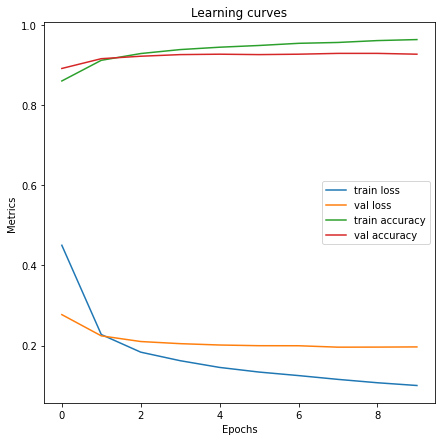

In [10]:
hist2 = model2.fit(MNetV2_features_train, y_train, epochs=50, validation_split=.15, callbacks=callback("MNetDNN")).history
show_result(hist2)

In [11]:
model2 = load_model(data_path + "MNetDNN_model.h5")
y_pred = model2.predict(MNetV2_features_test)
y_pred[y_pred <= 0.5], y_pred[y_pred > 0.5] = 0, 1
print("Accuracy test set:",  accuracy_score(y_test, y_pred))

Accuracy test set: 0.9297495418448382


## Finally train the best model on the train-test

In [19]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

MNetV2_features = MNetV2.predict(X_combined)

Epoch 1/50
218/218 [==============================] - 1s 4ms/step - loss: 0.1273 - accuracy: 0.9537 - val_loss: 0.1861 - val_accuracy: 0.9324
Epoch 2/50
218/218 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.9592 - val_loss: 0.1883 - val_accuracy: 0.9324
Epoch 3/50
218/218 [==============================] - 0s 2ms/step - loss: 0.1077 - accuracy: 0.9615 - val_loss: 0.1811 - val_accuracy: 0.9365
Epoch 4/50
218/218 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9635 - val_loss: 0.1854 - val_accuracy: 0.9365
Epoch 5/50
218/218 [==============================] - 1s 2ms/step - loss: 0.0956 - accuracy: 0.9663 - val_loss: 0.1871 - val_accuracy: 0.9340


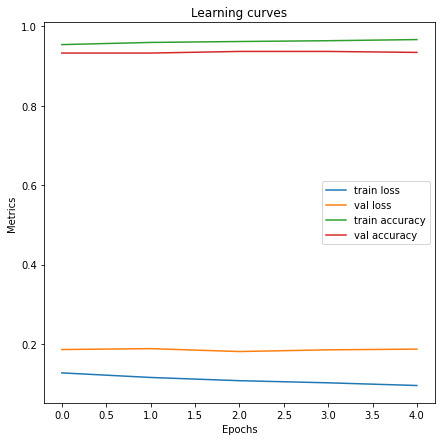

In [20]:
hist2 = model2.fit(MNetV2_features, y_combined, epochs=50, validation_split=.15, callbacks=callback("MNetDNN")).history
show_result(hist2)